In [1]:
import sys
import os
changed_dir = False
if(not changed_dir):
    os.chdir(os.path.join(os.getcwd(), "../"))
    sys.path.append(os.getcwd())
    print(os.getcwd())
    changed_dir = True

/home/anupa/Netmon/NetMon-query-planner/gurobi


In [2]:
'''
Goal: Find best overlay for a given input
'''
import numpy as np
import random
import math
import time
import ipdb
import traceback

from input import dc_topology, eps0
from main import solve
from config import common_config
from common import setup_logging, Namespace
import matplotlib.pyplot as plt

def flatten(l):
    ret = []
    for x in l:
        if(isinstance(x, list)):
            ret.extend(flatten(x))
        else:
            ret.append(x)
    return ret


INP = dc_topology(hosts_per_tors=8, num_queries=4*40, tenant=True,
                  overlay='tor', refine=True,
                  queries_per_tenant=40)
x0 = np.array(flatten(INP.overlay))

ELEMENTS_PER_PART = 8
NITER = 500

OPT = 2105
SPECTRALA = 2134
TENANT = 2135
TOR = 2295
RANDOM = 2315

TSTART = (RANDOM - OPT) / 2
TSTOP = 5

common_config.solver = 'Netmon'
common_config.vertical_partition = True
common_config.prog_dir = None
setup_logging(common_config)


class Anneal():

    def __init__(self, func, x0, Tstart, Tstop, take_step,
                 alpha=0.995, niter=100, callback=None):
        self.func = func
        self.x0 = x0
        self.Tstart = Tstart
        self.Tstop = Tstop
        self.niter = niter
        self.take_step = take_step
        self.alpha = alpha
        self.callback = callback

    def accept_reject(self, energy_new, energy_old):
        if(energy_new < energy_old):
            return True
        else:
            # import ipdb; ipdb.set_trace()
            # print("DeltaE: {}".format(energy_new - energy_old))
            # print("Exp: {}".format( -(energy_new - energy_old)/self.T ))
            # print("Prob: {}".format(math.exp(
            #     -(energy_new - energy_old)/self.T)))
            return random.random() <= math.exp(
                -(energy_new - energy_old)/self.T
            )

    def anneal(self):

        x = self.x0
        f = self.func(x)
        if(getattr(self, 'callback', None)):
            self.callback(x, f, True)

        self.iteration = 0
        self.T = self.Tstart
        while self.T >= self.Tstop and self.iteration < self.niter:

            x_after_step = np.copy(x)
            x_after_step = self.take_step(x_after_step)
            f_after_step = self.func(x_after_step)
            accept = self.accept_reject(f_after_step, f)

            if(getattr(self, 'callback', None)):
                val = self.callback(x_after_step, f_after_step, accept)
                if(val):
                    break

            if(accept):
                f = f_after_step
                x = x_after_step

            self.T *= self.alpha
            self.iteration += 1


class TakeStep():
    def __init__(self, stepsize=1):
        self.stepsize = stepsize

    def __call__(self, perm):
        n = len(perm)
        l = random.randint(2, int((n - 1) * self.stepsize))
        i = random.randint(0, n - l)
        perm = perm.tolist()
        perm[i: (i + l)] = reversed(perm[i: (i + l)])
        return np.array(perm)


class Callback():
    def __init__(self):
        self.data = []
        self.best = Namespace(x=x0, f=func(x0))

    def __call__(self, x, f, accept):
        print(x, f, accept)
        self.data.append(tuple((x, f, accept)))
        if(accept):
            if(f < self.best.f):
                self.best.x = x
                self.best.f = f

        if(abs(f - OPT) < TSTOP):
            return True


# No side effects
def get_overlay_from_perm(perm):
    n = len(perm)
    split_parts = math.floor(n/ELEMENTS_PER_PART)
    covered_elements = split_parts * ELEMENTS_PER_PART
    splits = np.split(
        perm[:covered_elements],
        split_parts)
    splits = [x.astype(int).tolist() for x in splits]
    splits.append(perm[covered_elements:].astype(int).tolist())
    return splits


def func(perm):
    INP.overlay = get_overlay_from_perm(perm)
    # start = time.time()
    (ns, res) = solve(INP)
    # print(ns, res)
    # end = time.time()
    return res  # ((res + 10000) * ns)/1000

Function: dc_topology took 0.0009243488311767578 seconds
Function: dc_topology took 0.0007646083831787109 seconds
Function: dc_topology took 0.0036177635192871094 seconds
Function: dc_topology took 0.2872154712677002 seconds
Function: dc_topology took 0.0010061264038085938 seconds
Buliding spectral overlay with 39 devices
Function: get_spectral_overlay took 0.028361082077026367 seconds
Function: dc_topology took 0.030252695083618164 seconds
Function: dc_topology took 0.1290452480316162 seconds
Buliding spectral overlay with 983 devices
Function: get_spectral_overlay took 0.6132247447967529 seconds
Function: dc_topology took 0.6202244758605957 seconds
Function: dc_topology took 0.6256871223449707 seconds
Function: dc_topology took 0.0014145374298095703 seconds


In [3]:
cb = Callback()
ts = TakeStep()
simanneal = Anneal(func, x0,
                   take_step=ts, callback=cb, Tstart=TSTART, Tstop=TSTOP,
                   niter=NITER)
simanneal.anneal()
print(cb.best)

Using license file /home/anupa/gurobi.lic
Academic license - for non-commercial use only
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38] 2295.9152482657805 True
[ 0  1  2  3  4  5  6  7  8  9 10 37 36 35 34 33 32 31 30 29 28 27 26 25
 24 23 22 21 20 19 18 17 16 15 14 13 12 11 38] 2255.081326441744 True
[ 0 38 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 10  9  8  7  6  5  4  3  2  1] 2265.0786484556834 True
[ 0 38 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27  2  3  4  5  6
  7  8  9 10 37 36 35 34 33 32 31 30 29 28  1] 2224.030770249636 True
[30 31 32 33 34 35 36 37 10  9  8  7  6  5  4  3  2 27 26 25 24 23 22 21
 20 19 18 17 16 15 14 13 12 11 38  0 29 28  1] 2184.9494113019687 True
[30 31 32 33 34 35 36 37 10  9  8  7  6  5  4  3  2 27 26 25 20 21 22 23
 24 19 18 17 16 15 14 13 12 11 38  0 29 28  1] 2194.9494113019687 False
[30 31 32 33 34 35 36 37 10  9  8  7  6  5  4  3

[17 22  9 34  6 18 38 12 14 11 26 16 37 20 15 35  7 13 19 30 29 33 36 25
 27  3  2  4  5 28  0 31  8 24  1 32 10 21 23] 2204.5428373469063 True
[17 22  9 34  6 18 38 12 14 11 26 16 37 20 15 35  7 13 19 30 29 33 36 25
 27  3  2  4  5 23 21 10 32  1 24  8 31  0 28] 2184.5832826954256 True
[17 22 19 13  7 35 15 20 37 16 26 11 14 12 38 18  6 34  9 30 29 33 36 25
 27  3  2  4  5 23 21 10 32  1 24  8 31  0 28] 2194.327068611293 True
[17 22 19 13  7 35 15 20 37 16 26 11 14 12 38 18  6 34  9 30 29 33 36 25
  5  4  2  3 27 23 21 10 32  1 24  8 31  0 28] 2194.327068611293 True
[17 22 19 13  7 35 15 20 37 16 26 34  6 18 38 12 14 11  9 30 29 33 36 25
  5  4  2  3 27 23 21 10 32  1 24  8 31  0 28] 2193.925529482393 True
[17 22 19 13  7 35  4  5 25 36 33 29 30  9 11 14 12 38 18  6 34 26 16 37
 20 15  2  3 27 23 21 10 32  1 24  8 31  0 28] 2214.7849781522327 True
[17 22 19 13  7 30 29 33 36 25  5  4 35  9 11 14 12 38 18  6 34 26 16 37
 20 15  2  3 27 23 21 10 32  1 24  8 31  0 28] 2214.1540141835794 

[11  5 13 16 37 20 15  2  3 32 14 22  8 18  6  7 35 27  9 23 21 10 24 25
 19 30 36 28 31  4  0 38 29 17 34  1 33 12 26] 2193.4391880037083 True
[11  5 13 16 37 20 15  2  3 32 14 19 25 24 10 21 23  9 27 35  7  6 18  8
 22 30 36 28 31  4  0 38 29 17 34  1 33 12 26] 2214.0035354726883 True
[12 33  1 34 17 29 38  0  4 31 28 36 30 22  8 18  6  7 35 27  9 23 21 10
 24 25 19 14 32  3  2 15 20 37 16 13  5 11 26] 2184.4995031895314 True
[12  4  0 38 29 17 34  1 33 31 28 36 30 22  8 18  6  7 35 27  9 23 21 10
 24 25 19 14 32  3  2 15 20 37 16 13  5 11 26] 2184.0495615268965 True
[12  4  0 38 29 17 34  1 33 31 28 36 21 23  9 27 35  7  6 18  8 22 30 10
 24 25 19 14 32  3  2 15 20 37 16 13  5 11 26] 2204.1735034134454 True
[12  4  0 38 29 17 34  1 33 31 28 36 21 23  9 27 35  7  6 18  8 22 30 10
 24 25  3 32 14 19  2 15 20 37 16 13  5 11 26] 2204.1735034134454 True
[12  4  0 38 29 17 34  1 33 31 28 36 21 23  9 27 35  3 25 24 10 30 22  8
 18  6  7 32 14 19  2 15 20 37 16 13  5 11 26] 2194.71693439749

[18  3 30 38  5 11 26 35 25  4  6  7  2  1 16 37  8 33  0 19 36 23  9 27
 29 24 22 10 34 13 14 21 28 20 31 15 32 12 17] 2173.8394643618108 True
[18  3 30 38  5 11 26 35 25  4  6  7  2  1 16 28 21 14 13 34 10 22 24 29
 27  9 23 36 19  0 33  8 37 20 31 15 32 12 17] 2184.8037411239056 True
[18  3 30 38  5 11 26 35 25  4  6  7  2  1 16 28 24 22 10 34 13 14 21 29
 27  9 23 36 19  0 33  8 37 20 31 15 32 12 17] 2184.803741166163 True
[18 36 23  9 27 29 21 14 13 34 10 22 24 28 16  1  2  7  6  4 25 35 26 11
  5 38 30  3 19  0 33  8 37 20 31 15 32 12 17] 2194.647095116235 True
[18 36 23  9 27 29 21 14 13 34 10 22 24 28 16  1 15 31 20 37  8 33  0 19
  3 30 38  5 11 26 35 25  4  6  7  2 32 12 17] 2174.620833761003 True
[18 36 23  9 27 29 21 14 13 34 10 30  3 19  0 33  8 37 20 31 15  1 16 28
 24 22 38  5 11 26 35 25  4  6  7  2 32 12 17] 2184.1284109582284 False
[18 36 23  9  3 19  0 33  8 37 20 31 15  1 16 28 24 22 10 34 13 14 21 29
 27 30 38  5 11 26 35 25  4  6  7  2 32 12 17] 2174.60254643441 T

[21 29  0  3 18 14 32  1 15 31 20  7  4 33 28  2  6 22 10 34 16 38 27 26
 17 11  5 30 13 35 25 12 24 23  9  8 37 36 19] 2203.516448309158 False
[21 29 36 37  8  9 23 24 12 25 35 13 30  5 11 17  7  4 33 28  2  6 22 10
 34 16 38 27 26 20 31 15  1 32 14 18  3  0 19] 2184.2865735982164 True
[21  8 37 36 29  9 23 24 12 25 35 13 30  5 11 17  7  4 33 28  2  6 22 10
 34 16 38 27 26 20 31 15  1 32 14 18  3  0 19] 2184.2865735982164 True
[21  8 37 36  2 28 33  4  7 17 11  5 30 13 35 25 12 24 23  9 29  6 22 10
 34 16 38 27 26 20 31 15  1 32 14 18  3  0 19] 2203.728789518116 True
[ 1 15 31 20 26 27 38 16 34 10 22  6 29  9 23 24 12 25 35 13 30  5 11 17
  7  4 33 28  2 36 37  8 21 32 14 18  3  0 19] 2193.643524813194 True
[ 1 15 31 20 26 27 38 16 34  6 22 10 29  9 23 24 12 25 35 13 30  5 11 17
  7  4 33 28  2 36 37  8 21 32 14 18  3  0 19] 2193.643524813194 True
[24 23  9 29 10 22  6 34 16 38 27 26 20 31 15  1 12 25 35 13 30  5 11 17
  7  4 33 28  2 36 37  8 21 32 14 18  3  0 19] 2193.643524813194 T

[32 38  3 14 13 21 28 26 27 18 30  1 19 34 16  8 29 22 10  6 25 20 36 31
 15 23 11  5 12  9  0  2  4 24 17  7 33 37 35] 2255.3479261275925 False
[37 33  7 17 24  4  8 29 22 10  6 25 20 36 31 15 23 11  5 12  9  0  2 16
 34 19  1 30 18 27 26 28 21 13 14  3 38 32 35] 2244.5410029552486 False
[32 38  3 21 13 14 28 26 27 18 30  1 19 34 16  2  0  9 12  5 11 23 15 31
 36 20 25  6 10 22 29  8  4 24 17  7 33 37 35] 2214.848205889942 True
[32 38  3 21 13 14 28 26 27 18 30  1 19 34 16  2  0  9 12  4  8 29 22 10
  6 25 20 36 31 15 23 11  5 24 17  7 33 37 35] 2203.6822195964724 True
[32 38  3 21 13 14 28 26 27 18 30  1 19 34 16  2  0  9 12  4 35 37 33  7
 17 24  5 11 23 15 31 36 20 25  6 10 22 29  8] 2194.635283865534 True
[32 38  3 21 13 14 28 29 22 10  6 25 20 36 31 15 23 11  5 24 17  7 33 37
 35  4 12  9  0  2 16 34 19  1 30 18 27 26  8] 2235.278355683856 False
[32 38  3 21 13 14 28 26 27 18 30  1 19 34 16  2 11  5 24 17  7 33 37 35
  4 12  9  0 23 15 31 36 20 25  6 10 22 29  8] 2204.25168488167

[12 28 14 25 20 23  5  2 18 30 34 17  7 33 31 24 15 37 36 38  9 32  8 10
 22 29  6 13 21 16 26  1 19 35  3  0  4 11 27] 2224.426011593238 True
[12 28  5 23 20 25 14  2 18 30 34 17  7 33 31 24 15 37 36 38  9 32  8 10
 22 29  6 13 21 16 26  1 19 35  3  0  4 11 27] 2224.426011593238 True
[11  4  0  3 35 19  1 26 16 21 13  6 29 22 10  8 32  9 38 36 37 15 24 31
 33  7 17 34 30 18  2 14 25 20 23  5 28 12 27] 2215.3261160987136 True
[11  4  0  3 35 19  1 26 16 21 13  6 29 22 10 27 12 28  5 23 20 25 14  2
 18 30 34 17  7 33 31 24 15 37 36 38  9 32  8] 2314.8270154663596 False
[11  4  0  3 35 19  1 26 16 21 13  6 29 22 14  2 18 30 34 17  7 33 31 24
 15 37 36 38  9 32  8 10 25 20 23  5 28 12 27] 2214.967514232209 True
[11  4  0  3 35 28  5 23 20 25 10  8 32  9 38 36 37 15 24 31 33  7 17 34
 30 18  2 14 22 29  6 13 21 16 26  1 19 12 27] 2304.8247040279034 False
[11  4  0  3 35 19  1 37 15 24 31 33  7 17 34 30 18  2 14 22 29  6 13 21
 16 26 36 38  9 32  8 10 25 20 23  5 28 12 27] 2193.820779577496

[22 24  2 33 31  1 12 27  5 23 34  8 19  6 13  9 21 38 36 32  3  4 30 18
  0 10 26 37 15 25 28 11  7 29 16 17 20 14 35] 2204.4355534222054 True
[22 24  2 33 31  1 12 27  5 23 34  8 19  6 13  9 21 38 36 32  3  4 30 18
  0 10 26 37 11 28 25 15  7 29 16 17 20 14 35] 2194.5588970539834 True
[22 27 12  1 31 33  2 24  5 23 34  8 19  6 13  9 21 38 36 32  3  4 30 18
  0 10 26 37 11 28 25 15  7 29 16 17 20 14 35] 2204.555994856998 False
[22 24  2 33 31  1 12 27  5 23 34  8 19  6 14 20 17 16 29  7 15 25 28 11
 37 26 10  0 18 30  4  3 32 36 38 21  9 13 35] 2243.879832114614 False
[22 24  2 33 31  1 12 27  5 23 34  8 19  6 13  9 21 38 36 32  3 10  0 18
 30  4 26 37 11 28 25 15  7 29 16 17 20 14 35] 2174.6689083017372 True
[22 24  2 33 31  1 12 27  5 36 38 21  9 13  6 19  8 34 23 32  3 10  0 18
 30  4 26 37 11 28 25 15  7 29 16 17 20 14 35] 2284.494084127544 False
[14 20 17 16 29  7 15 25 28 11 37 26  4 30 18  0 10  3 32 36 38 21  9 13
  6 19  8 34 23  5 27 12  1 31 33  2 24 22 35] 2224.73569565810

[ 2 33 25 28 26 37 11  4 32  3 10  0 17  9 31  1 12 27  5  7 15 14 20 30
 18 34 23 19 24 22  6 36 38 21 29 16 13  8 35] 2273.658645299143 False
[ 2 33 25 28 26 37 11  4 32  3 10  6 22 24 19  7 15 14 20 30 18 34 23  5
 27 12  1 31  9 17  0 36 38 21 29 16 13  8 35] 2274.484741682636 False
[ 2 29 21 38 36  6 22 24 19  7 15 14 20 30 18 34 23  5 27 12  1 31  9 17
  0 10  3 32  4 11 37 26 28 25 33 16 13  8 35] 2244.5778282584633 False
[ 2 33 25 28  7 15 14 20 30 18 34 23  5 27 12  1 31  9 17  0 10  3 32  4
 11 37 26 19 24 22  6 36 38 21 29 16 13  8 35] 2192.953755205347 False
[ 2 33 25 28 26 37 11  4 32  3 10  0 17  9 31  1 12 27  5 23 34  6 22 24
 19  7 15 14 20 30 18 36 38 21 29 16 13  8 35] 2173.976446371159 True
[ 2 33 25 28 26 37 11  4 35  8 13 16 29 21 38 36 18 30 20 14 15  7 19 24
 22  6 34 23  5 27 12  1 31  9 17  0 10  3 32] 2294.7555290870596 False
[ 2 33 25 28 26 37 11  4 32  3 10  0 17  9 35  8 13 16 29 21 38 36 18 30
 20 14 15  7 19 24 22  6 34 23  5 27 12  1 31] 2214.1778528562

In [4]:
get_overlay_from_perm(x0)

[[0, 1, 2, 3, 4, 5, 6, 7],
 [8, 9, 10, 11, 12, 13, 14, 15],
 [16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31],
 [32, 33, 34, 35, 36, 37, 38]]

In [5]:
import input
from input import draw_overlay_over_tenant, draw_graph

In [6]:
import importlib
importlib.reload(input)

<module 'input' from '/home/anupa/Netmon/NetMon-query-planner/gurobi/input.py'>

In [7]:
ov = get_overlay_from_perm(cb.best.x)
ov

[[18, 14, 21, 29, 3, 19, 0, 33],
 [8, 37, 20, 31, 15, 11, 5, 38],
 [16, 28, 25, 35, 26, 1, 30, 27],
 [9, 23, 36, 13, 34, 10, 22, 24],
 [4, 6, 7, 2, 12, 32, 17]]

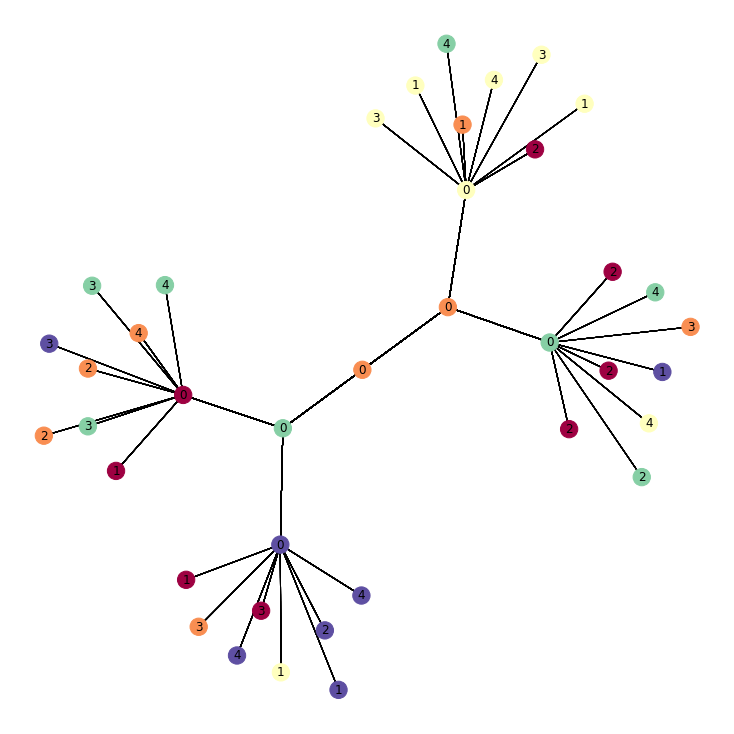

In [8]:
INP.overlay = ov
draw_overlay_over_tenant(INP)

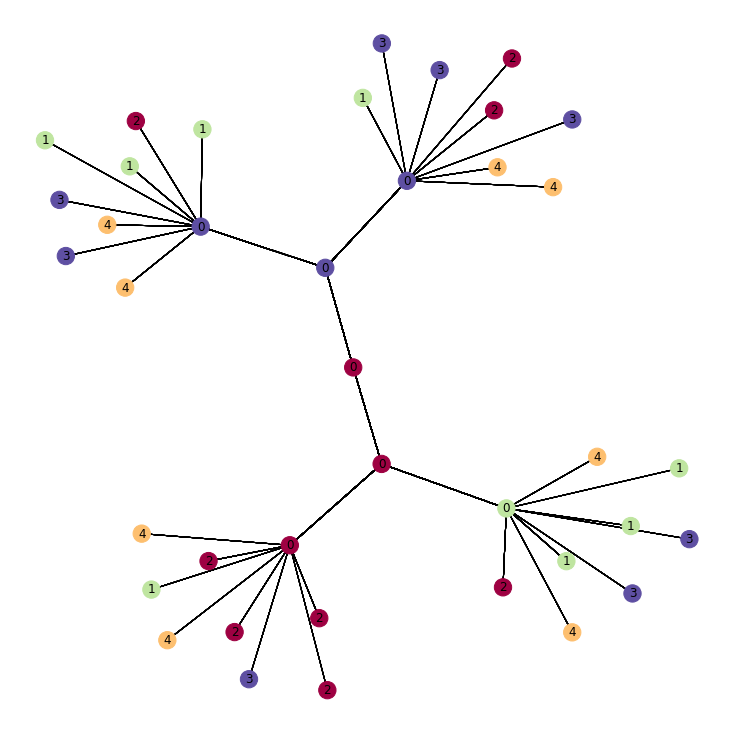

In [9]:
specA = dc_topology(hosts_per_tors=8, num_queries=4*40, tenant=True,
            overlay='spectralA', refine=True,
            queries_per_tenant=40)
draw_overlay_over_tenant(specA)

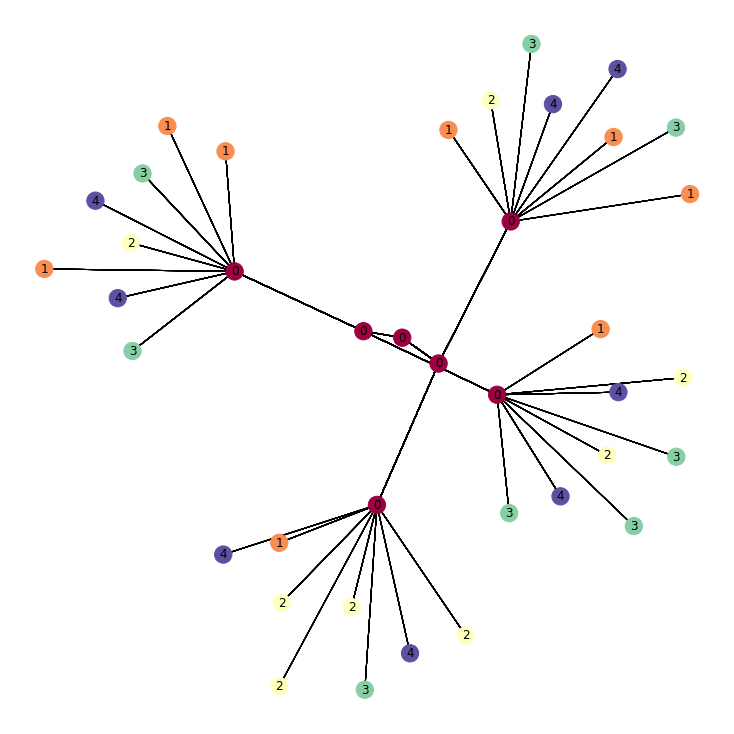

In [10]:
ten = dc_topology(hosts_per_tors=8, num_queries=4*40, tenant=True,
            overlay='tenant', refine=True,
            queries_per_tenant=40)
draw_overlay_over_tenant(ten)

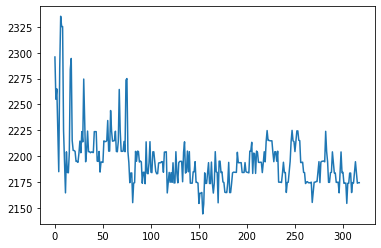

In [11]:
# import pickle
# cb_file = open('pickle_objs/cb', 'wb')
# pickle.dump(cb, cb_file)
# cb_file.close()
plt.plot([x[1] for x in cb.data if x[2]])

cb.data.sort(key=lambda x: x[1])

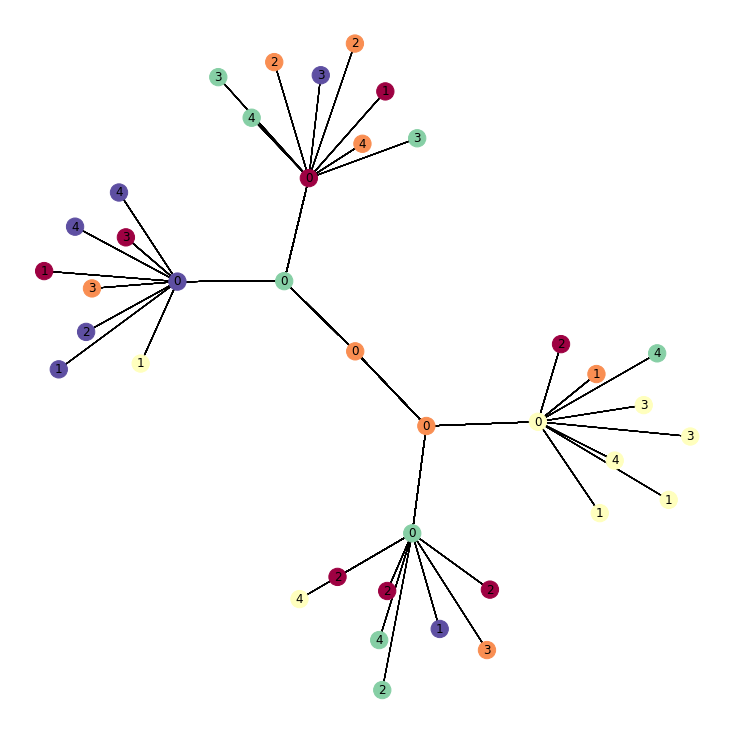

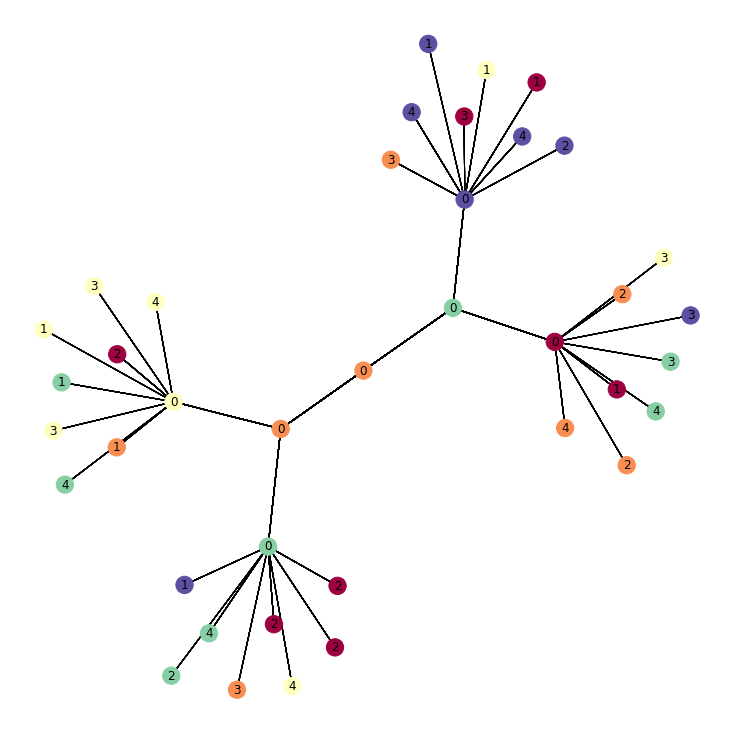

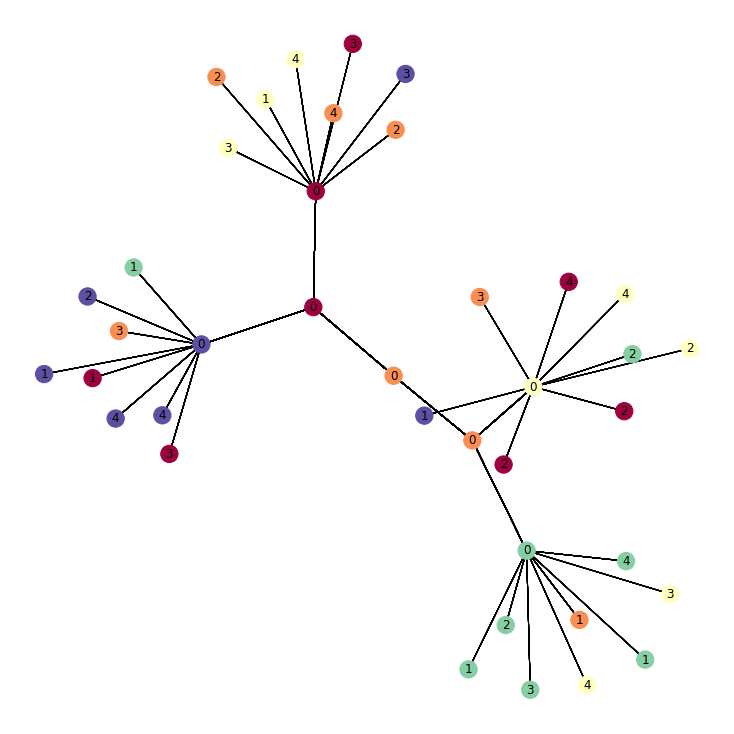

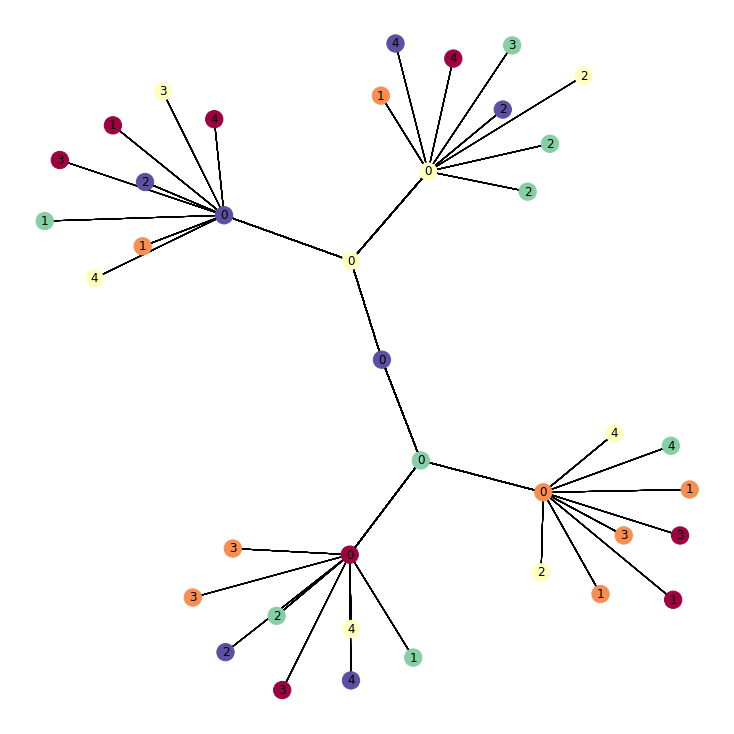

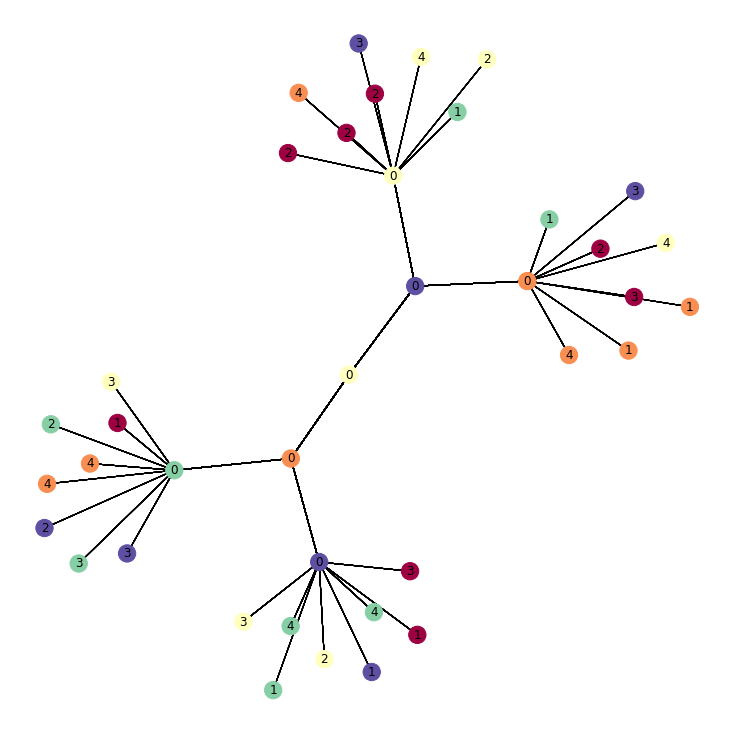

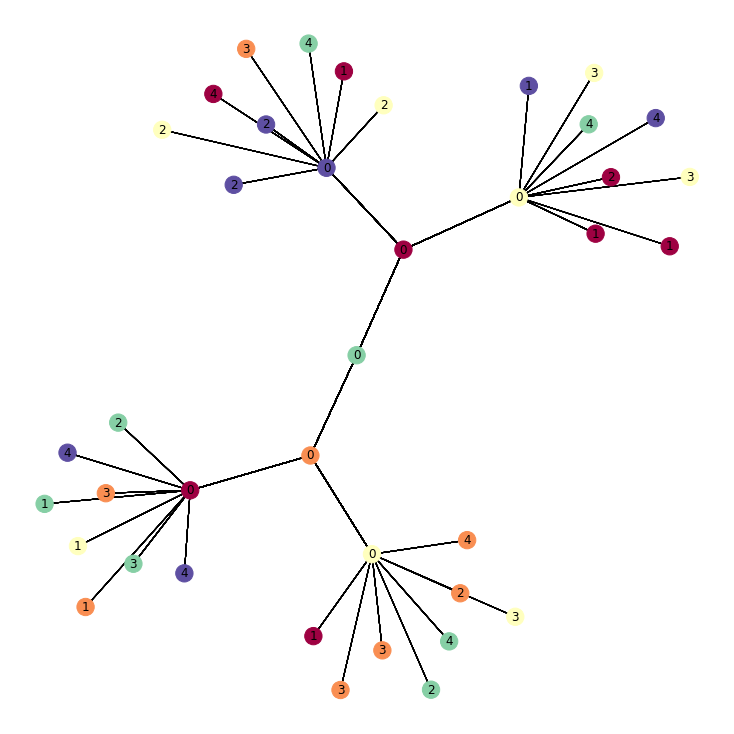

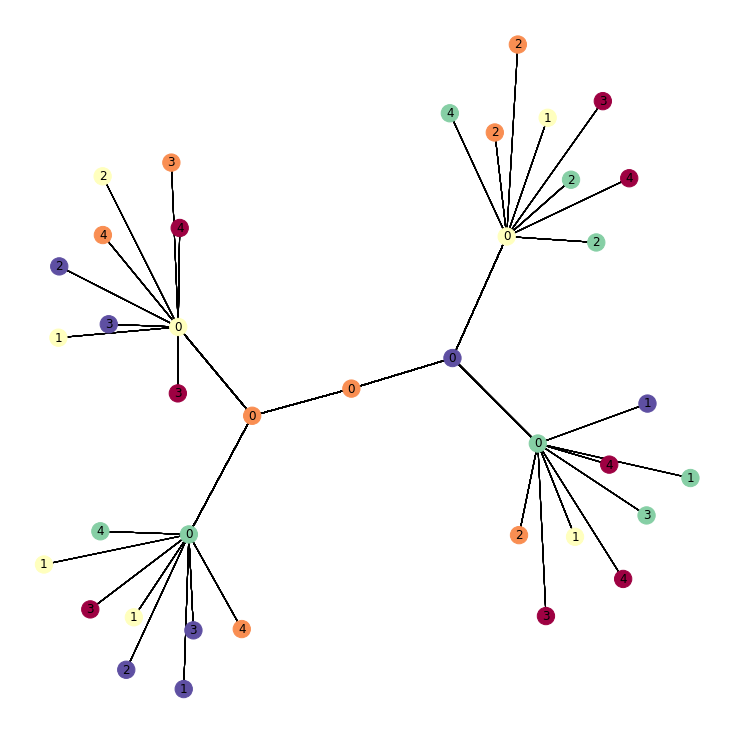

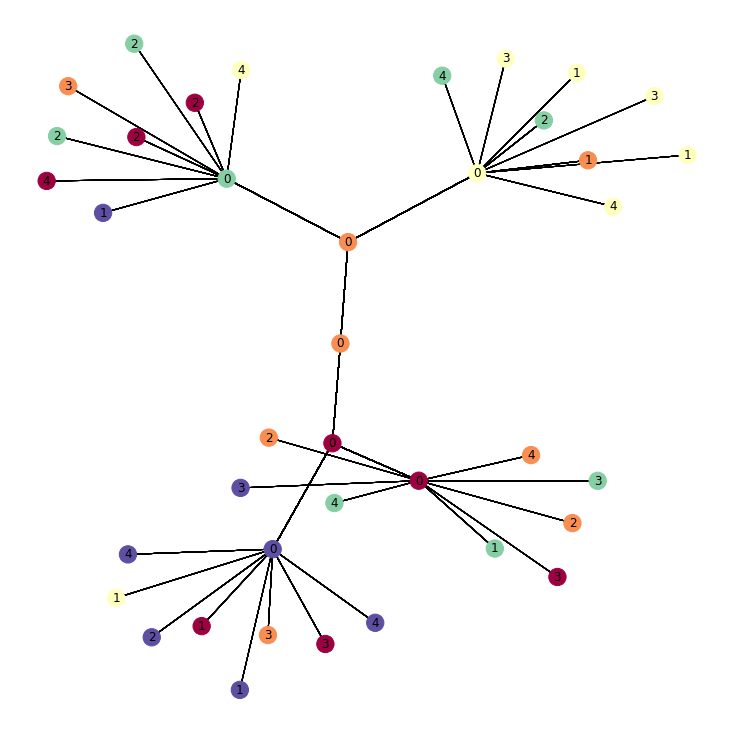

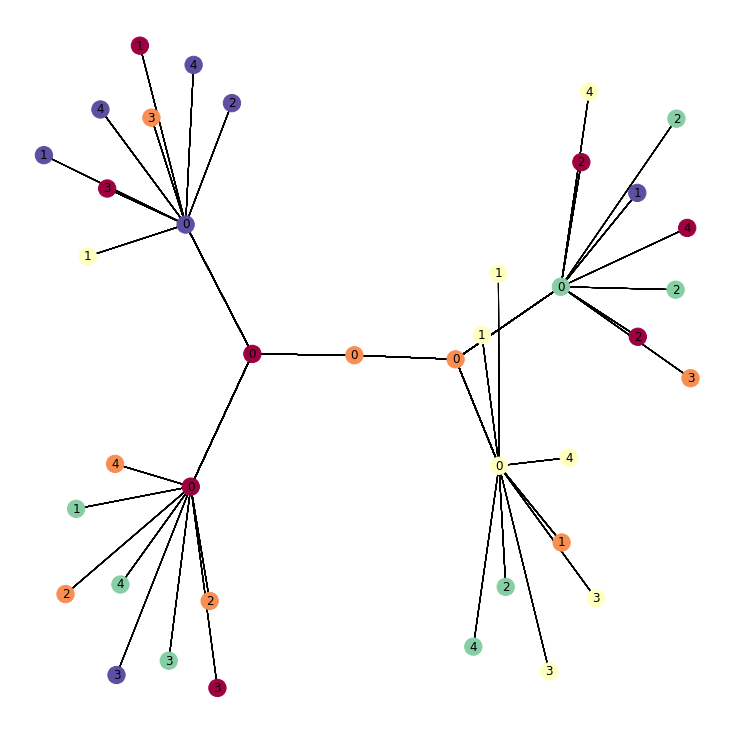

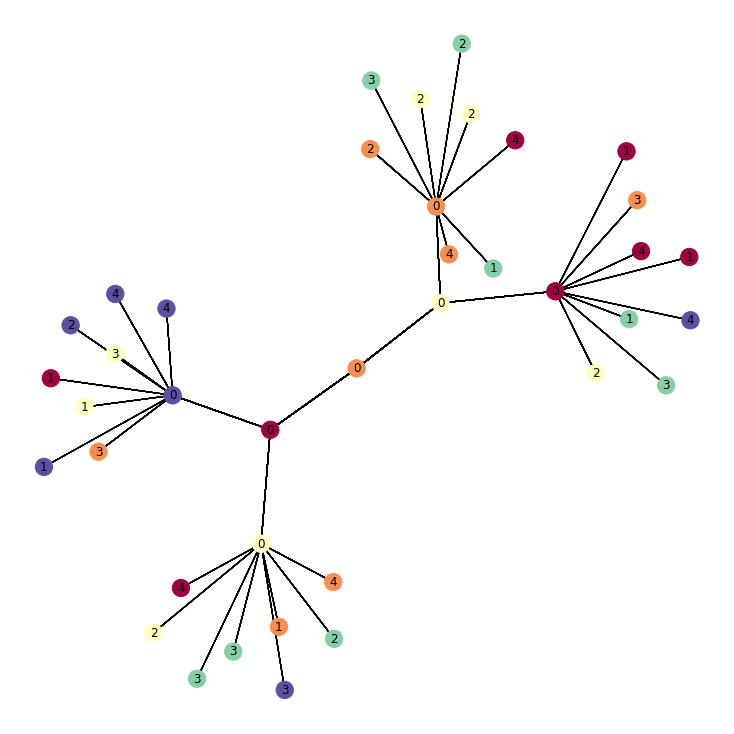

In [12]:
for i in range(10):
    ov = get_overlay_from_perm(cb.data[i][0])
    INP.overlay = ov
    draw_overlay_over_tenant(INP)